# Image Processing SS 20 - Assignment - 07

### Deadline is 10.6.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import chelsea
from skimage.color import rgb2gray
from math import e,pi,sqrt
    
from numpy.fft import fft2 as numpy_fft2, ifft2 as numpy_ifft2

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

In [3]:
def dft_matrix(n):
    """
    Returns the Discrete Fourier Transformation Matrix of order `n`.
    """
    omega = np.exp( - 2 * np.pi * 1J / n )
    W = np.ones((n,n), dtype=complex)
    for x in range(W.shape[0]):
        for y in range(W.shape[1]):
            W[x,y] = omega**(x*y)
    return W  # / np.sqrt(n)

# Exercise 1 - 2D DFT - 2 Points
Implement the 2D Discrete Fourier Transformation with [Matrix Multiplication](https://en.wikipedia.org/wiki/DFT_matrix). You can use your code from the last assignment to compute the dct matrix.

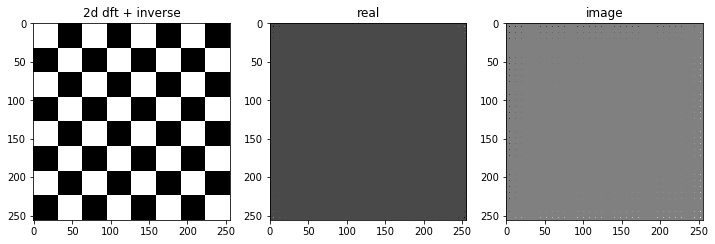

In [4]:
def dft2d(img):
    """
    Returns the 2d discrete fourier transformation
    """  
    matrixL = dft_matrix(img.shape[0])
    matrixR = dft_matrix(img.shape[1])
    return (matrixL @ img @ matrixR)

def inv_dft2d(x):
    """
    Returns the 2d inverse discrete fourier transformation
    """
    matrixL = dft_matrix(x.shape[0])
    matrixR = dft_matrix(x.shape[1]) 
    return np.conjugate(matrixL) @ x @ np.conjugate(matrixR)


def chess_board(n=8, field_size=32):
    board = np.zeros((n*field_size, n*field_size))
    s = field_size
    for i in range(n):
        for j in range(n):
            if (i + j) % 2 == 0:
                board[i*s:(i+1)*s, j*s:(j+1)*s] = 1
    return board


plt.subplot(131)
plt.title('2d dft + inverse')
plt.imshow(abs(inv_dft2d(dft2d(chess_board() ))), cmap='gray')
plt.subplot(132)
plt.title('real')
plt.imshow(np.real(dft2d( chess_board() )), cmap='gray')
plt.subplot(133)
plt.title('image')
plt.imshow(np.imag(dft2d(chess_board())), cmap='gray')
plt.show()
 

# Exercise 2 - High and Low Pass filter with the 2D fourier transformation - 3 Points

In [5]:
def high_pass(img_ft, n): 
    ft = img_ft.copy()
    ft[:n, :n] = 0
    ft[-n:, :n] = 0
    ft[-n:, -n:] = 0
    ft[:n, -n:] = 0
    return ft

def low_pass(img_ft, n):
    ft = img_ft.copy()
    ft[n:-n,:] = 0
    ft[:,n:-n] = 0
    return ft

def band_pass(img_ft, low, high):
    result = low_pass(img_ft, high)
    result = high_pass(result, low)
    return result
    
def inv_dft_and_plot(img_ft):
    plt.imshow(np.real(inv_dft2d(img_ft)), cmap='gray')
    plt.show()

## for verification

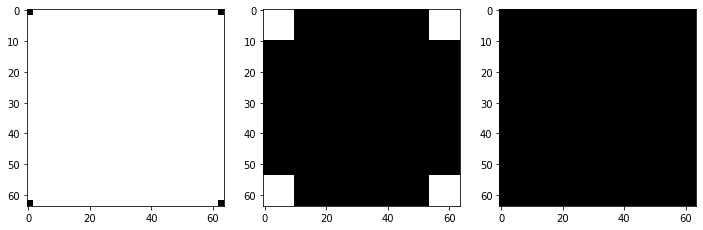

In [6]:
img2 = np.ones((64,64))

plt.subplot(131)
plt.imshow( high_pass(img2, 2) , cmap='gray')
plt.subplot(132)
plt.imshow( low_pass(img2, 10), cmap='gray')
plt.subplot(133)
plt.imshow(band_pass(img2, 10 , 2) , cmap='gray')
plt.show()

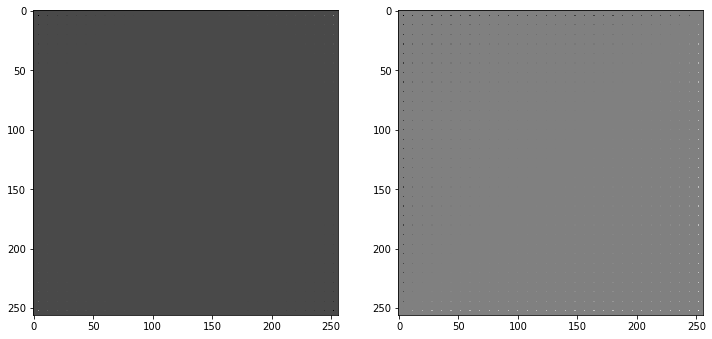

In [7]:
chess_board_ft = dft2d(chess_board())

# display frequency domain of the chess_board
plt.subplot(121)
plt.imshow(np.real(chess_board_ft), cmap='gray')
plt.subplot(122)
plt.imshow(np.imag(chess_board_ft), cmap='gray')
plt.show()

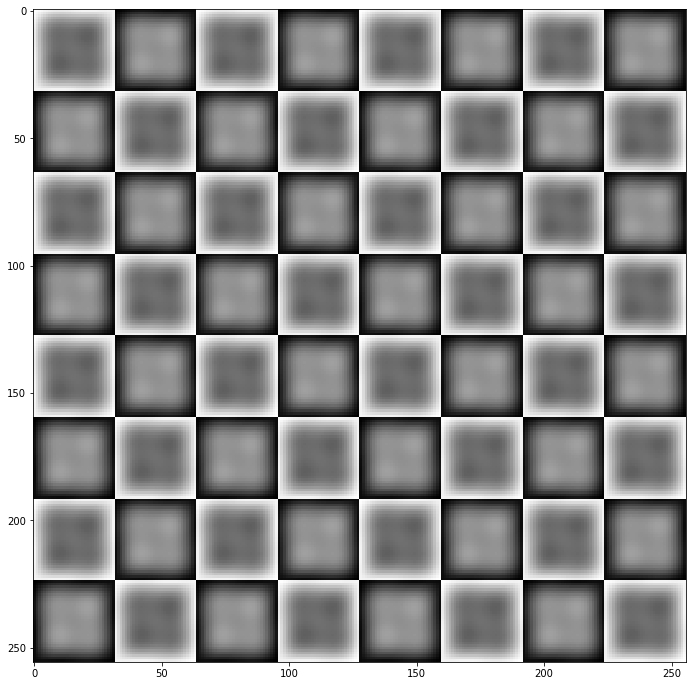

In [8]:
# remove the low frequencies of the chess board
chess_high_feq = high_pass(chess_board_ft, 12)
inv_dft_and_plot(chess_high_feq)

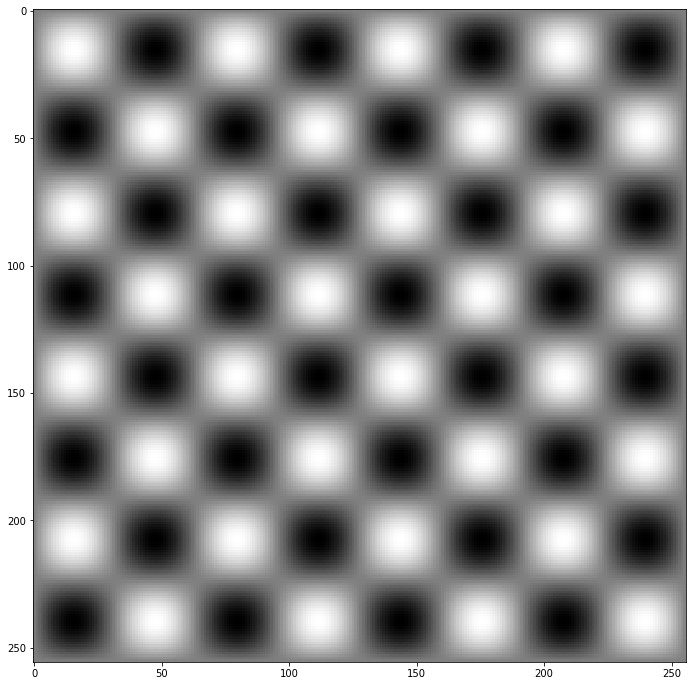

In [9]:
# remove the high frequencies of the chess board
chess_low_feq = low_pass(chess_board_ft, 10)
inv_dft_and_plot(chess_low_feq)

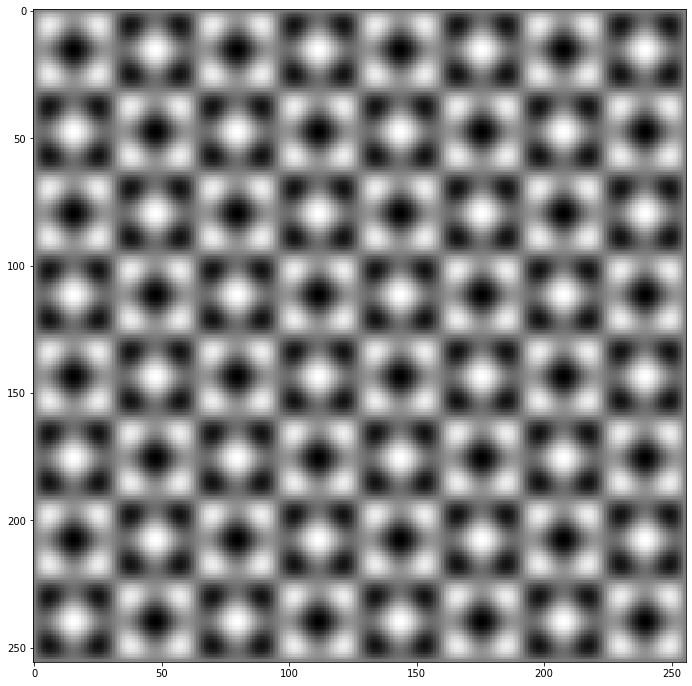

In [10]:
# remove the high frequencies of the chess board
chess_medium_feq = band_pass(chess_board_ft, 5, 15)
inv_dft_and_plot(chess_medium_feq)

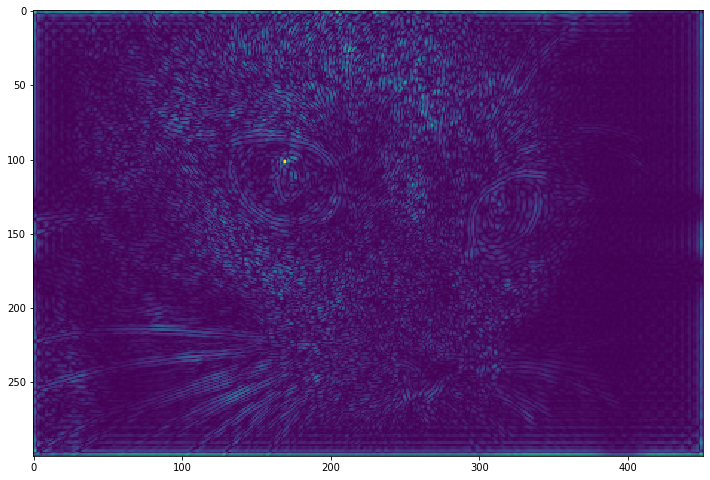

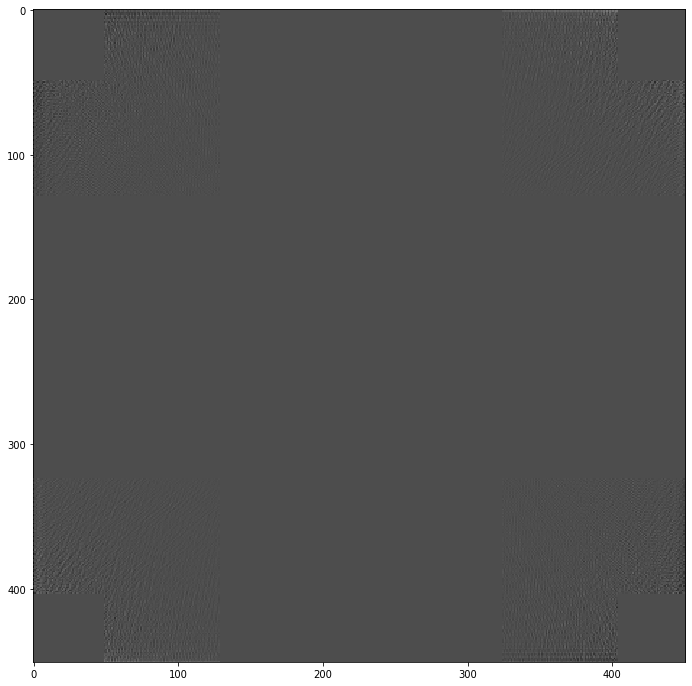

In [11]:
img = rgb2gray(chelsea() / 255)

# filter all frequencies corresponding to the coefficients between 48 and 128.
# your code here

maxs = np.amax(img.shape)

img_extended = np.zeros((maxs,maxs))
img_extended[:img.shape[0],:img.shape[1]] = img


ft = dft2d(img_extended)
ft_band = band_pass(ft,48,128)

inv_pic = inv_dft2d(ft_band)

plt.imshow(np.abs(inv_pic[:img.shape [0], :img.shape[1]] ))
plt.show()
inv_dft_and_plot(inv_pic)

# Exercise 3 - FFT - 5 Points

Implement the fast fourier transformation. 

Use the [Cooley-Tukey](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm) algorithm.

In [12]:
 # what is wrong here?   
def fft2(img):
    """
    Computes the fast fourier transformation of x.
    """

    # first: extend the picture to the power of 2. 
    maxs = np.amax(img.shape)
    power = np.where( np.fromfunction(lambda i: (2**i), (15,)) >= maxs) [0][0]
    value = 2 ** power
    img_e = np.zeros((value,value),dtype='complex') 
    img_e[:img.shape[0], :img.shape[1]] = img           
    img_e[:img.shape[0] , img.shape[1]:512] = img[:, :img_e.shape[1]-img.shape[1]]
    img_e[img.shape[0]:, :img.shape[1]] = img[:img_e.shape[0]-img.shape[0], :]
    img_e[img.shape[0]:512, img.shape[1]:512] = img[:img_e.shape[0]-img.shape[0], :img_e.shape[1]-img.shape[1]]


    # calculate for every row + col the Cooley Tukey algo. 
    for i, row in enumerate(img_e):
        img_e[i,:] = fft_recursion(row)
    for i, col in enumerate(img_e.T):
        img_e[:,i] = fft_recursion(col)     # error nr two: put result in the col

    return img_e


def fft(signal):
    """
    FFT for one dimensional signal. 
    """
    n = len(signal)
    maxs = np.amax(img.shape)
    power = np.where( np.fromfunction(lambda i: (2**i), (15,)) >= n) [0][0]
    value = 2 ** power
    signal_ext = np.zeros(value)
    # extend the signal to the power of 2.
    signal_ext[:n] = signal
    signal[n:] = signal[:value - n]
    # calculate the Cooley Tukey algo.
    return fft_recursion(signal_ext)
    

def fft_recursion(row):
    """
    Cooley Tukey algorithm. 
    """
    if( row.shape[0] == 2):
        return dft_matrix(2) @ row
 
    even = fft_recursion(row [::2])
    odd = fft_recursion(row [1::2])

    n_id = np.arange(row.shape[0])
    w = e ** (-1j * 2 * np.pi * n_id / row.shape[0]) 

    odd = np.concatenate((odd,odd))
    even = np.concatenate((even,even))
    return even + odd * w




In [13]:
img = rgb2gray((chelsea() / 255) )
fft_img = fft2(img)

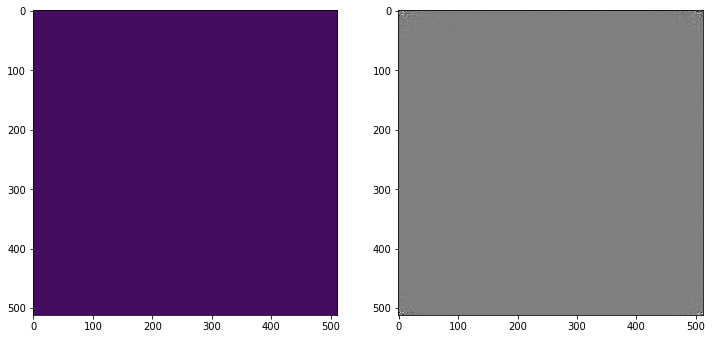

In [14]:
plt.subplot(121)
plt.imshow(np.real(fft_img))
plt.subplot(122)
plt.imshow(np.imag(fft_img) , cmap='gray')
plt.show() 

In [15]:
img_re = inv_dft2d(fft_img)

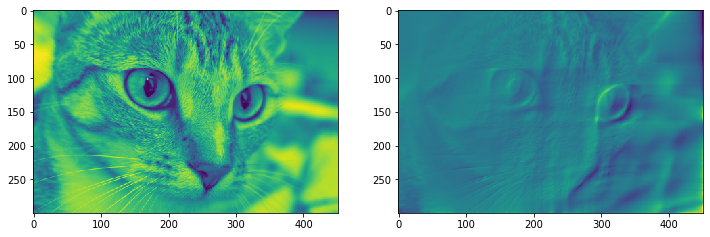

In [16]:
plt.subplot(121)
plt.imshow(abs(img_re[:img.shape[0] , : img.shape[1]]  ))
plt.subplot(122)
plt.imshow(np.imag(img_re[:img.shape[0] , : img.shape[1]] ))
plt.show()